# Geospatial Analysis of Crash Cases in Philadelphia from 2010 - 2021

This data is aggregated by Police District.

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [89]:
# Spatial Plot
philly_map = geopandas.read_file("./Boundaries_District/Boundaries_District.shp")
philly_map_2 = philly_map.copy()

# Crash Dataset
df = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_general.csv")

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_82568/1481085912.py:5: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/pongyizhen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Y2S2_Citadel comps/APAC_2023_Datasets/Crashes/crash_info_general.csv")


In [96]:
#add binary column for small automobile count
df['small_automobiles'] = (df['MOTORCYCLE_COUNT']).apply(lambda x: 1 if x > 0 else 0)

In [97]:
# Create GeoSpatial DataFrame
crashes_coords = geopandas.GeoDataFrame(
    df,
    geometry=geopandas.points_from_xy(df['DEC_LONG'], df['DEC_LAT'])
)

In [98]:
# Map to district
crashes_coords['DISTRICT_'] = ''
for idx in range(philly_map.shape[0]):
    pip = crashes_coords.within(philly_map.loc[idx, 'geometry'])
    if pip.sum() > 0:
        crashes_coords.loc[pip, 'DISTRICT_'] = philly_map.loc[idx, 'DISTRICT_']
  

In [99]:
#Filter out invalid cases that do not fall within the districts
crashes_coords = crashes_coords[crashes_coords['DISTRICT_'] != '']


In [100]:
#group by district and count, before filtering for heavy vehicles
stats_before_filter = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

print(stats_before_filter)

             CRN
DISTRICT_       
1           3333
2           6270
3           6475
5           1999
6           6995
7           4272
8           7706
9           4967
12          8005
14          5866
15         12130
16          8840
17          2537
18          7567
19          4887
22          6135
24          6893
25          7485
26          5183
35          7089
39          6890
77            44


In [101]:
# Filter cases with small automobiles
crashes_coords = crashes_coords[crashes_coords['small_automobiles'] == 1]

In [102]:
#Group by district and count
stats = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

stats = stats.sort_values(by="CRN", ascending=False)
print(stats)

           CRN
DISTRICT_     
15         372
25         311
24         249
3          240
16         231
39         197
12         183
8          181
22         179
26         175
35         171
6          162
2          148
18         139
9          120
19         104
14          95
1           81
7           67
17          64
5           60
77           2


In [103]:
stats_ratio = stats.merge(stats_before_filter, on = 'DISTRICT_')
stats_ratio['ratio'] = stats_ratio['CRN_x']/ stats_ratio['CRN_y']


stats_ratio = stats_ratio.sort_values(by="ratio", ascending=False)
print(stats_ratio)

           CRN_x  CRN_y     ratio
DISTRICT_                        
77             2     44  0.045455
25           311   7485  0.041550
3            240   6475  0.037066
24           249   6893  0.036124
26           175   5183  0.033764
15           372  12130  0.030668
5             60   1999  0.030015
22           179   6135  0.029177
39           197   6890  0.028592
16           231   8840  0.026131
17            64   2537  0.025227
1             81   3333  0.024302
9            120   4967  0.024159
35           171   7089  0.024122
2            148   6270  0.023604
8            181   7706  0.023488
6            162   6995  0.023159
12           183   8005  0.022861
19           104   4887  0.021281
18           139   7567  0.018369
14            95   5866  0.016195
7             67   4272  0.015684


In [104]:
# Merge count into map
map_and_stats = philly_map.merge(stats, on='DISTRICT_')

# Merge count into map if we using stats ratio
#map_and_stats = philly_map.merge(stats_ratio, on='DISTRICT_')

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

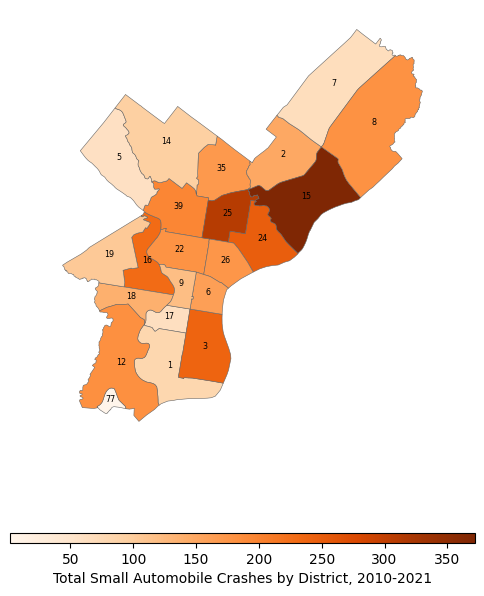

In [105]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats.plot(
    column='CRN',
    cmap='Oranges',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Total Small Automobile Crashes by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')

KeyError: 'ratio'

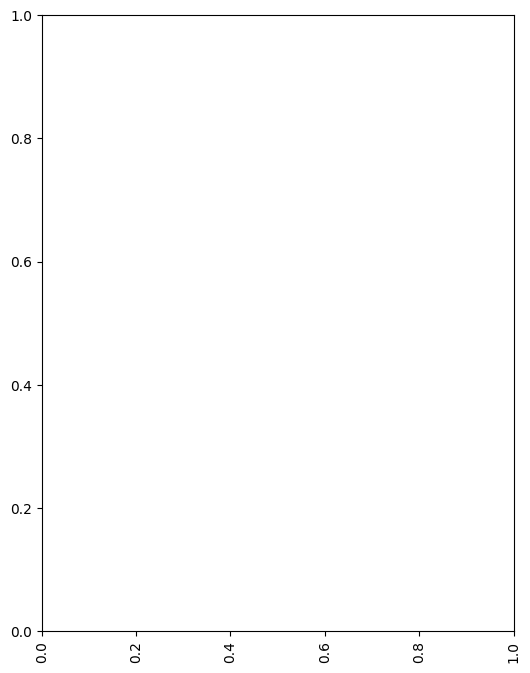

In [106]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats.plot(
    column='ratio',
    #column='CRN',
    cmap='Oranges',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Ratio of Small Automobile Crashes by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')

In [ ]:
""" fig, ax = plt.subplots(1, figsize=(8,8))
plt.xticks(rotation=90)
map_and_stats.plot(
    column='CRN',
    cmap='Oranges',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4'
)

bar_info = plt.cm.ScalarMappable(
    cmap='Oranges',
    norm=plt.Normalize(vmin=0, vmax=400),
)
bar_info._A = []
cbar = fig.colorbar(bar_info)
ax.axis('off') """

" fig, ax = plt.subplots(1, figsize=(8,8))\nplt.xticks(rotation=90)\nmap_and_stats.plot(\n    column='CRN',\n    cmap='Oranges',\n    linewidth=0.4,\n    ax=ax,\n    edgecolor='.4'\n)\n\nbar_info = plt.cm.ScalarMappable(\n    cmap='Oranges',\n    norm=plt.Normalize(vmin=0, vmax=400),\n)\nbar_info._A = []\ncbar = fig.colorbar(bar_info)\nax.axis('off') "